# Experiment

In [1]:
import pandas as pd
import numpy as np
import torch
import os
from IPython.display import display
import matplotlib.pyplot as plt

from models import get_global_threshold, get_individual_thresholds
from models import get_global_similarity_log_reg, get_similarity_log_reg
from models import get_embeddings_log_reg
from models import get_global_sim_X_y, get_concept_sim_X_y

from calibration_framework import apply_platt_scaling, apply_isotonic_regression, apply_temperature_scaling

from utils import compare_all_models_calibration_metric, compare_all_models_calibration_avg, compare_all_models_calibration_concept

In [2]:
dataset_name = 'CLEVR'

## 1. Get pre-processed data

In [3]:
metadata_df = pd.read_csv(f'../Data/{dataset_name}/metadata.csv')
embeddings = torch.load(f'Embeddings/{dataset_name}/embeddings.pt')
cosine_similarity_df = pd.read_csv(f'Cosine_Similarities/{dataset_name}/train_cosine_similarities.csv')

if dataset_name == 'CLEVR':
    metadata_df = metadata_df.drop(['size::large','material::rubber'], axis=1)
    cosine_similarity_df = cosine_similarity_df.drop(['size::large','material::rubber'], axis=1)

concepts = list(cosine_similarity_df.columns)

train_mask = metadata_df['split'] == 'train'
train_embeddings = embeddings[train_mask]
train_metadata_df = metadata_df[train_mask].reset_index(drop=True)
train_cosine_similarity_df = cosine_similarity_df[train_mask].reset_index(drop=True)

cal_mask = metadata_df['split'] == 'calibration'
cal_embeddings = embeddings[cal_mask]
cal_metadata_df = metadata_df[cal_mask].reset_index(drop=True)
cal_cosine_similarity_df = cosine_similarity_df[cal_mask].reset_index(drop=True)

test_mask = metadata_df['split'] == 'test'
test_embeddings = embeddings[test_mask]
test_metadata_df = metadata_df[test_mask].reset_index(drop=True)
test_cosine_similarity_df = cosine_similarity_df[test_mask].reset_index(drop=True)

In [4]:
embeddings.shape

torch.Size([1001, 768])

In [5]:
cosine_similarity_df.shape

(1001, 6)

## 2. Train models

### (GT) Global Threshold

In [6]:
m1_models, m1_global_train_error, m1_train_errors = get_global_threshold(train_metadata_df, train_cosine_similarity_df,
                                                                        verbose=False)
m1_train_errors['Model'] = 'GT'

### (CT) Concept Threshold

In [7]:
m2_models, m2_train_errors = get_individual_thresholds(train_metadata_df, train_cosine_similarity_df, verbose=False)
m2_train_errors['Model'] = 'CT'

### (GLR) Global Similarity LogReg

In [8]:
m3_models, m3_global_train_error, m3_train_errors = get_global_similarity_log_reg(train_metadata_df, 
                                                                                  train_cosine_similarity_df,
                                                                                  verbose=False)
m3_train_errors['Model'] = 'GLR'

### (CLR) Concept Similarity LogReg

In [9]:
m4_models, m4_train_errors = get_similarity_log_reg(train_metadata_df, train_cosine_similarity_df, verbose=False)
m4_train_errors['Model'] = 'CLR'

### (EmbCLR) Embeddings Concept LogReg

In [10]:
m5_models, m5_train_errors = get_embeddings_log_reg(train_embeddings, train_metadata_df, train_cosine_similarity_df,
                                                   verbose=False)
m5_train_errors['Model'] = 'EmbCLR'

In [11]:
base_models = {'GT': m1_models,
               'CT': m2_models,
               'GLR': m3_models,
               'CLR': m4_models,
               'EmbCLR': m5_models
         }

### 2.1 Evaluate training classification error

In [12]:
error_comparison_df = pd.DataFrame.from_dict([m1_train_errors, 
                                              m2_train_errors,
                                              m3_train_errors,
                                              m4_train_errors,
                                              m5_train_errors
                                             ])
error_comparison_df = error_comparison_df.set_index('Model')
if dataset_name == 'CUB':
    error_comparison_df = error_comparison_df.transpose()
    display(error_comparison_df.describe())
else:
    display(error_comparison_df)

,color::blue,color::green,color::red,shape::cube,shape::cylinder,shape::sphere
Model,,,,,,
GT,0.0,0.0,0.0,0.0,0.003257,0.000000
CT,0.0,0.0,0.0,0.0,0.006515,0.001629
GLR,0.0,0.0,0.0,0.0,0.004886,0.000000
CLR,0.0,0.0,0.0,0.0,0.006515,0.000000
EmbCLR,0.0,0.0,0.0,0.0,0.001629,0.000000


## 3. Calibrate models

In [13]:
X_cal, y_cal, _, _ = get_global_sim_X_y(cal_metadata_df, cal_cosine_similarity_df)

m3_models_cal = {}

m3_models_cal['Platt'] = apply_platt_scaling(m3_models, X_cal, y_cal)
m3_models_cal['Isotonic'] = apply_isotonic_regression(m3_models, X_cal, y_cal)
m3_models_cal['Temperature'] = apply_temperature_scaling(m3_models, X_cal, y_cal, verbose=False)

In [14]:
m4_models_cal = {}
m4_models_cal['Platt'] = {}
m4_models_cal['Isotonic'] = {}
m4_models_cal['Temperature'] = {}

for concept in m4_models.keys():
    X_cal, y_cal = get_concept_sim_X_y(cal_metadata_df, cal_cosine_similarity_df, concept)

    m4_models_cal['Platt'][concept] = apply_platt_scaling(m4_models[concept], X_cal, y_cal)
    m4_models_cal['Isotonic'][concept] = apply_isotonic_regression(m4_models[concept], X_cal, y_cal)
    m4_models_cal['Temperature'][concept] = apply_temperature_scaling(m4_models[concept], X_cal, y_cal, verbose=False)

In [15]:
m5_models_cal = {}
m5_models_cal['Platt'] = {}
m5_models_cal['Isotonic'] = {}
m5_models_cal['Temperature'] = {}

for concept in m5_models.keys():
    X_cal = cal_embeddings
    y_cal = (cal_metadata_df[concept]==1).to_numpy().astype(int)

    m5_models_cal['Platt'][concept] = apply_platt_scaling(m5_models[concept], X_cal, y_cal)
    m5_models_cal['Isotonic'][concept] = apply_isotonic_regression(m5_models[concept], X_cal, y_cal)
    m5_models_cal['Temperature'][concept] = apply_temperature_scaling(m5_models[concept], X_cal, y_cal, verbose=False)

In [16]:
calibrated_models = {'GLR': m3_models_cal,
                     'CLR': m4_models_cal,
                     'EmbCLR': m5_models_cal
                    }

## 4. Evaluate models

In [17]:
results_path = f"Results/{dataset_name}/"
os.makedirs(results_path, exist_ok=True)

### 4.1 Get a single metric for all models, calibration methods, and concepts

**Use only if you don't have many concepts!**

In [18]:
metric = 'K1'

if len(concepts) <= 10:
    metric_df = compare_all_models_calibration_metric(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                       test_metadata_df, test_cosine_similarity_df, test_embeddings, 
                                       metric=metric)
    if not 'K' in metric:
        display(metric_df.style.highlight_max(color='grey'))
    else:
        display(metric_df)

color::blue color::green color::red shape::cube  \
Model  Calibration                                                   
GT     None                  -            -          -           -   
CT     None                  -            -          -           -   
GLR    None           0.648546     0.706546   0.661221    0.683988   
       Platt          0.646244     0.707305    0.65412    0.690015   
       Isotonic       0.002371          0.0   0.000807         0.0   
       Temperature    0.568577     0.595522   0.574098    0.585503   
CLR    None           0.644621     0.700931   0.653584    0.689736   
       Platt          0.639222     0.707101   0.653638    0.698309   
       Isotonic       0.015757     0.009366   0.000643    0.006758   
       Temperature    0.567093     0.593372   0.571179    0.588015   
EmbCLR None            0.64805     0.702044   0.649981    0.690408   
       Platt          0.643526     0.706619   0.648215    0.694403   
       Isotonic       0.009759     0.020205        0.0    0.002994   
       Temperature    0.568467     0.593936   0.569551    0.588226   

                   shape::cylinder shape::sphere  
Model  Calibration                                
GT     None                      -             -  
CT     None                      -             -  
GLR    None                0.65394      0.642954  
       Platt              0.661118      0.643542  
       Isotonic                0.0           0.0  
       Temperature        0.571711      0.566105  
CLR    None               0.664961      0.641935  
       Platt              0.662754      0.642366  
       Isotonic            0.01017      0.010207  
       Temperature        0.576359       0.56572  
EmbCLR None               0.667493      0.642783  
       Platt              0.663869      0.643205  
       Isotonic           0.019987      0.010757  
       Temperature        0.577461      0.566079

### 4.2 Get the average of all metrics over the concepts for all models and calibration methods

In [19]:
metrics_avg_df = compare_all_models_calibration_avg(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                   test_metadata_df, test_cosine_similarity_df, test_embeddings)
metrics_avg_df.to_csv(os.path.join(results_path, 'metrics_average.csv'))
with open(os.path.join(results_path, 'metrics_average.tex'), 'w') as tf:
     tf.write(metrics_avg_df.to_latex())

with open(os.path.join(results_path, 'metrics_average_short.tex'), 'w') as tf:
     tf.write(metrics_avg_df[['Acc','K1','Kmax']].to_latex())
    
metrics_avg_df#.style.highlight_max(color='grey', subset=['Acc','F1','AUC'])

Acc           F1          AUC           K1  \
Model  Calibration                                                       
GT     None         1.00 ± 0.00  1.00 ± 0.00            -            -   
CT     None         1.00 ± 0.00  1.00 ± 0.00            -            -   
GLR    None         1.00 ± 0.00  1.00 ± 0.00  1.00 ± 0.00  0.67 ± 0.02   
       Platt        1.00 ± 0.00  1.00 ± 0.00  1.00 ± 0.00  0.67 ± 0.03   
       Isotonic     1.00 ± 0.00  1.00 ± 0.00  1.00 ± 0.00  0.00 ± 0.00   
       Temperature  1.00 ± 0.00  1.00 ± 0.00  1.00 ± 0.00  0.58 ± 0.01   
CLR    None         1.00 ± 0.00  1.00 ± 0.00  1.00 ± 0.00  0.67 ± 0.02   
       Platt        1.00 ± 0.00  1.00 ± 0.00  1.00 ± 0.00  0.67 ± 0.03   
       Isotonic     1.00 ± 0.00  1.00 ± 0.00  1.00 ± 0.00  0.01 ± 0.00   
       Temperature  1.00 ± 0.00  1.00 ± 0.00  1.00 ± 0.00  0.58 ± 0.01   
EmbCLR None         1.00 ± 0.00  1.00 ± 0.00  1.00 ± 0.00  0.67 ± 0.02   
       Platt        1.00 ± 0.00  1.00 ± 0.00  1.00 ± 0.00  0.67 ± 0.03   
       Isotonic     1.00 ± 0.00  1.00 ± 0.00  1.00 ± 0.00  0.01 ± 0.01   
       Temperature  1.00 ± 0.00  1.00 ± 0.00  1.00 ± 0.00  0.58 ± 0.01   

                             K2         Kmax  
Model  Calibration                            
GT     None                   -            -  
CT     None                   -            -  
GLR    None         0.65 ± 0.03  0.65 ± 0.03  
       Platt        0.66 ± 0.03  0.66 ± 0.03  
       Isotonic     0.00 ± 0.00  0.00 ± 0.00  
       Temperature  0.38 ± 0.01  0.47 ± 0.03  
CLR    None         0.62 ± 0.03  0.61 ± 0.05  
       Platt        0.65 ± 0.03  0.65 ± 0.03  
       Isotonic     0.01 ± 0.00  0.01 ± 0.00  
       Temperature  0.37 ± 0.01  0.43 ± 0.04  
EmbCLR None         0.62 ± 0.03  0.64 ± 0.03  
       Platt        0.66 ± 0.03  0.66 ± 0.03  
       Isotonic     0.01 ± 0.01  0.01 ± 0.01  
       Temperature  0.37 ± 0.01  0.46 ± 0.03

### 4.3 Get all metrics for all models and calibration methods for a single concept

In [20]:
concept = concepts[0]

metrics_concept_df = compare_all_models_calibration_concept(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                   test_metadata_df, test_cosine_similarity_df, test_embeddings,
                                      concept=concept)
metrics_concept_df.to_csv(os.path.join(results_path, f'metrics_concept_{concept}.csv'))
with open(os.path.join(results_path, f'metrics_concept_{concept}.tex'), 'w') as tf:
     tf.write(metrics_concept_df.to_latex())
    
metrics_concept_df.style.highlight_max(color='grey', subset=['Acc','F1','AUC'])  

In [21]:
if len(concepts) < 10:
    for concept in concepts:
        metrics_concept_df = compare_all_models_calibration_concept(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                           test_metadata_df, test_cosine_similarity_df, test_embeddings,
                                              concept=concept)
        metrics_concept_df.to_csv(os.path.join(results_path, f'metrics_concept_{concept}.csv'))
        with open(os.path.join(results_path, f'metrics_concept_{concept}.tex'), 'w') as tf:
             tf.write(metrics_concept_df.to_latex())

## 5. Calibration curves

In [22]:
from calibration import plot_calibration_curves_concept, plot_calibration_curves_avg

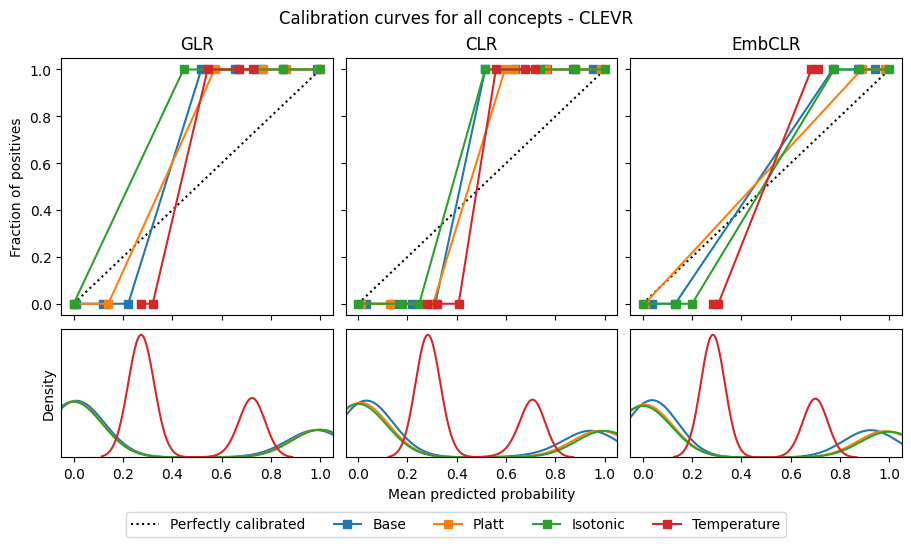

In [23]:
fig = plot_calibration_curves_avg(test_metadata_df, test_cosine_similarity_df, 
                                test_embeddings, base_models, calibrated_models,
                                  results_path, dataset_name)

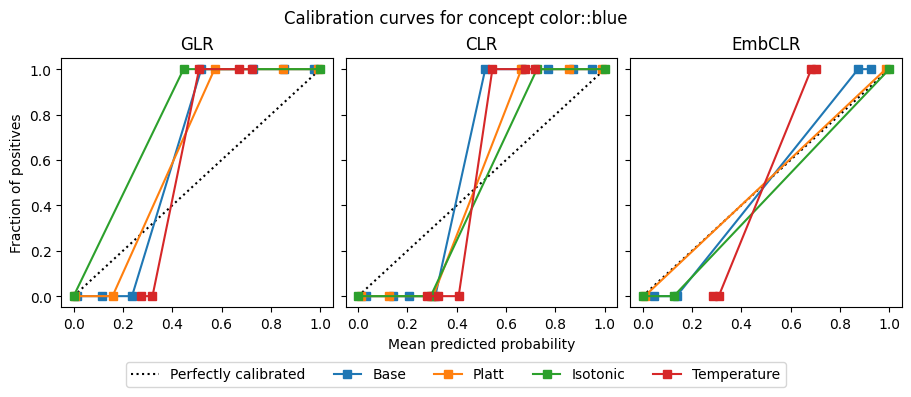

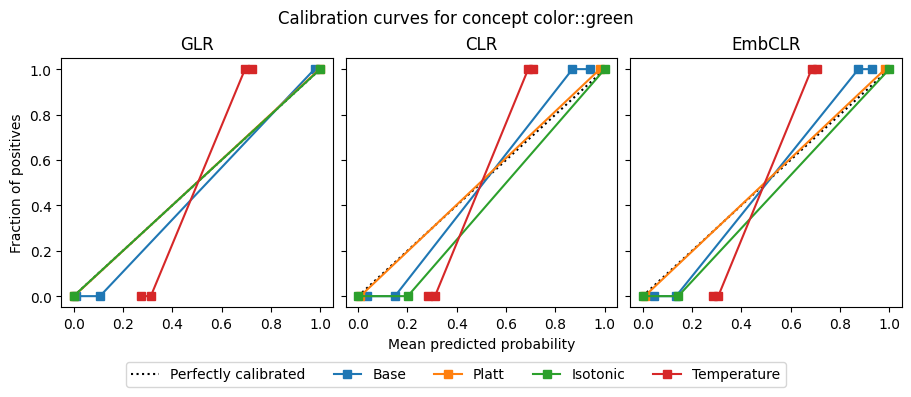

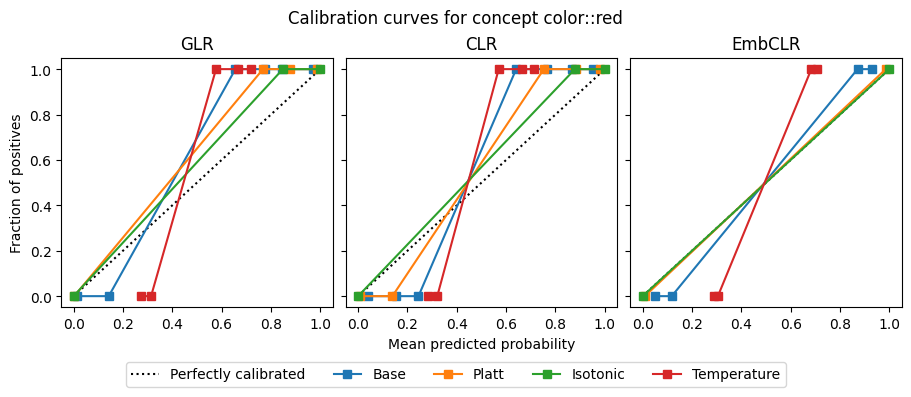

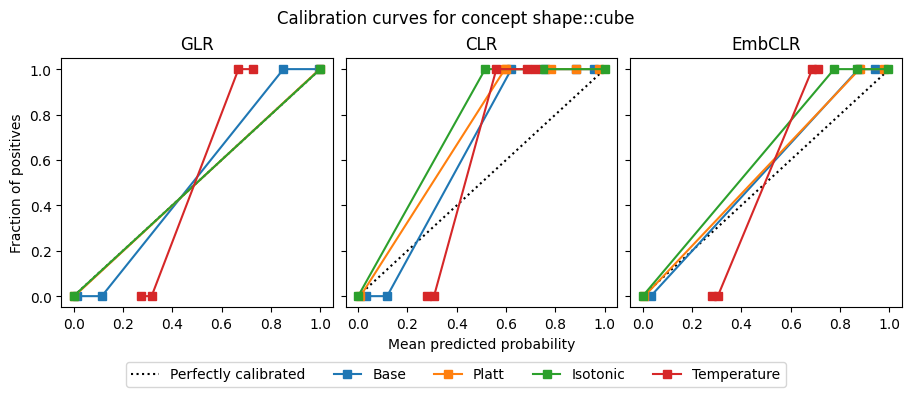

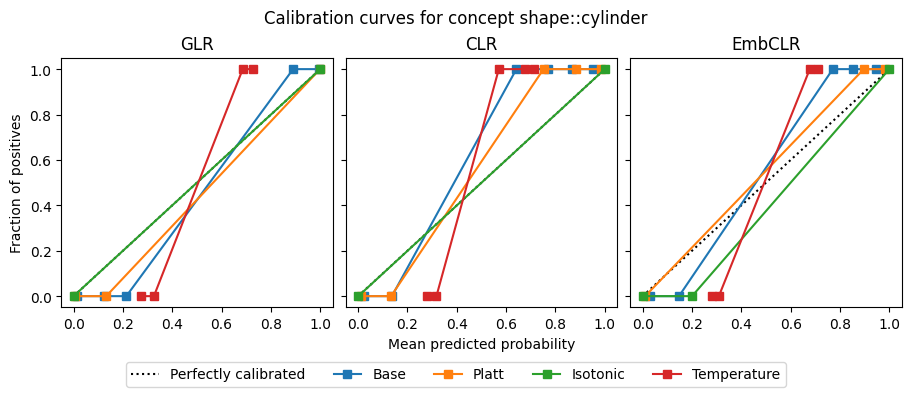

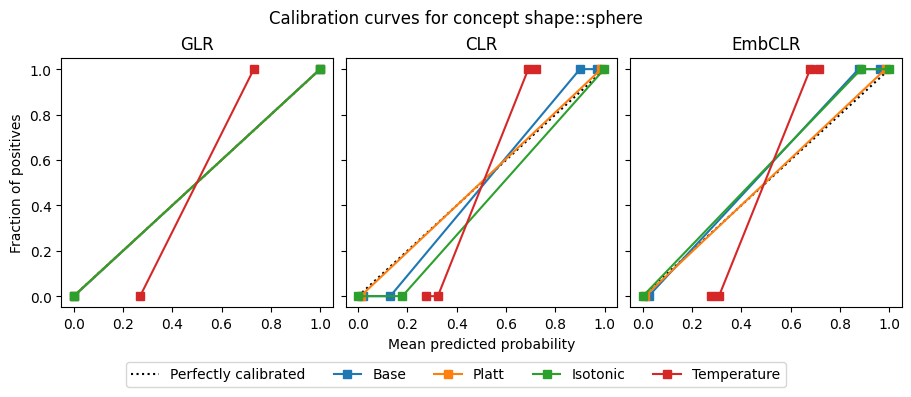

In [24]:
if len(concepts) < 10:
    for concept in concepts:
        fig = plot_calibration_curves_concept(test_metadata_df, test_cosine_similarity_df, 
                                            test_embeddings, base_models, calibrated_models,
                                            concept, results_path)
        fig.show()
else:
    for concept in concepts[:10]:
        fig = plot_calibration_curves_concept(test_metadata_df, test_cosine_similarity_df, 
                                            test_embeddings, base_models, calibrated_models,
                                            concept, results_path)
        fig.show()